## Feature Extraction Functions

In [1]:
from xml.dom import minidom
from collections import defaultdict 
import numpy as np
import editdistance
import random
import time

EMBEDDING_DIM = 16

MAXN_STATE_NODES = 400 # maximum number of state nodes used
MAX_TOKEN_LENGTH = 20 # maximum token length padded to

NODE_KEY_LIST = [ 
    # slot names (keys) of a node to add as features
    "index", # integer
    "checkable", "checked", "clickable", "enabled", "focusable", "focused", # boolean
    "scrollable", "long-clickable", "password", "selected", "visible-to-user", # boolean
    "bounds", # interval
    "content-desc", # string
    "resource-id", "class", "package", # formatted string
]
NODE_KEY_DICT = {NODE_KEY_LIST[i]:i for i in range(len(NODE_KEY_LIST))}

CHAR_LIST = ["<PAD>", "<UNK>"] +\
list("ABCDEFGHIJKLMNOPQRSTUVWXYZ") +\
list("abcdefghijklmnopqrstuvwxyz") +\
list("0123456789") +\
list("`~!@#$%^&*()_+-={}|[]:;'',.<>/?") +\
["\\"] + ['"']
CHAR_DICT = defaultdict(
    lambda:CHAR_LIST.index("<UNK>"), 
    {CHAR_LIST[i]:i for i in range(len(CHAR_LIST))}
)

PADDING_NODE_VECTOR = [ [CHAR_DICT["<PAD>"] for _ in range(MAX_TOKEN_LENGTH)] for _ in range(len(NODE_KEY_LIST))]

In [2]:
# specific method for target encoding
# similar to get_node_vector but without the node assumption
# arg_node is a list of strings
def get_sentence_vector(arg_sent):
    sent_vector = []
    for j in range(len(arg_sent)):
        chars_j = list(arg_sent[j])
        # get the indices for every char
        inds_j = [CHAR_DICT[chars_j[k]] for k in range( min(MAX_TOKEN_LENGTH,len(chars_j)) )]
        # pad the inds
        inds_j += [CHAR_DICT["<PAD>"]] * ( MAX_TOKEN_LENGTH-len(inds_j) )
        sent_vector.append(inds_j)
    return sent_vector

# arg_node is a gui element object
# (element from action list)
def get_element_vector(arg_elem):
    elem_vector = []
    for j in range(len(NODE_KEY_LIST)):
        key_j = NODE_KEY_LIST[j]
        str_j = str(arg_elem.attributes[key_j])
        chars_j = list(str_j)
        # get the indices for every char
        inds_j = [CHAR_DICT[chars_j[k]] for k in range( min(MAX_TOKEN_LENGTH,len(chars_j)) )]
        # pad the inds
        inds_j += [CHAR_DICT["<PAD>"]] * ( MAX_TOKEN_LENGTH-len(inds_j) )
        elem_vector.append(inds_j)
    return elem_vector

# arg_node is a ui element object
# (node from state)
def get_node_vector(arg_node):
    node_vector = []
    for j in range(len(NODE_KEY_LIST)):
        key_j = NODE_KEY_LIST[j]
        str_j = str(arg_node.attributes[key_j].value)
        chars_j = list(str_j)
        # get the indices for every char
        inds_j = [CHAR_DICT[chars_j[k]] for k in range( min(MAX_TOKEN_LENGTH,len(chars_j)) )]
        # pad the inds
        inds_j += [CHAR_DICT["<PAD>"]] * ( MAX_TOKEN_LENGTH-len(inds_j) )
        node_vector.append(inds_j)
    return node_vector

# a state here is a windows hierarchy string
def get_state_matrix(arg_wh):
    state_nodes = minidom.parseString(arg_wh).getElementsByTagName('node')
    state_matrix = []
    for i in range( min(MAXN_STATE_NODES,len(state_nodes)) ):
        state_vector = []
        node_i = state_nodes[i]
        node_vector_i = get_node_vector(node_i)
        state_matrix.append(node_vector_i)
    # pad the state matrix
    state_matrix += [PADDING_NODE_VECTOR] * ( MAXN_STATE_NODES-len(state_matrix) )
    return state_matrix

## Neural Agent
- UniversalTokenEncoder: relu
- StateEncoder: relu
- TargetEncoder: relu
- ActionEncoder: sigmoid

In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: {}".format(device))
print("torch version: {}".format(torch.__version__))

device: cpu
torch version: 1.6.0


In [4]:
class UniversalTokenEncoder(nn.Module):
    def __init__(self, arg_embedding_dim):
        super(UniversalTokenEncoder, self).__init__()
        self.embedding_dim = arg_embedding_dim
        self.char_embedding = nn.Embedding(
            num_embeddings=len(CHAR_LIST),
            embedding_dim=arg_embedding_dim,
        )
        self.n_kernels = [10, 10, 10]
        self.kernel_sizes = [1, 2, 3]
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=arg_embedding_dim, 
                out_channels=self.n_kernels[i], 
                kernel_size=self.kernel_sizes[i], 
                padding=0
            )
            for i in range(len(self.kernel_sizes))
        ])
        self.pools = nn.ModuleList([
            nn.MaxPool1d(MAX_TOKEN_LENGTH+1-self.kernel_sizes[i], padding=0)
            for i in range(len(self.kernel_sizes))
        ])
        self.linear = nn.Linear(sum(self.n_kernels), arg_embedding_dim)
        
    # input a batch of sequences (high-dimensional)
    # arg_seqs: (B=1, ??, len(NODE_KEY_LIST), MAX_TOKEN_LENGTH)
    # ??=MAXN_STATE_NODES if encoding state matrix
    # ??=1 if encoding the target
    # ??=others if encoding an action list
    def forward(self, arg_seqs):
        B = arg_seqs.shape[0]
        tmpn_nodes = arg_seqs.shape[1]
        tmp_dim0 = B * tmpn_nodes * len(NODE_KEY_LIST)
        assert B==1
        # first fold the first 3 dimensions
        tmp0 = arg_seqs.view(tmp_dim0, MAX_TOKEN_LENGTH) # (dim0, MAX_TOKEN_LENGTH)
        tmp1 = self.char_embedding(tmp0) # (dim0, MAX_TOKEN_LENGTH, embedding_dim)
        tmp2 = tmp1.transpose(1,2) # channel goes first for conv, (dim0, embedding_dim, MAX_TOKEN_LENGTH)
        # (dim0, n_kernels, MAX_TOKEN_LENGTH-i)
        tmp3s = [
            F.relu(self.convs[i](tmp2))
            for i in range(len(self.convs))
        ]
        # (dim0, n_kernels, 1)
        tmp4s = [
            self.pools[i](tmp3s[i])
            for i in range(len(tmp3s))
        ]
        # (dim0, n_kernels)
        tmp5s = [
            tmp4s[i].view(tmp_dim0, self.n_kernels[i])
            for i in range(len(tmp4s))
        ]
        tmp6 = torch.cat(tmp5s, 1) # (dim0, sum(n_kernels))
        tmp7 = F.relu(self.linear(tmp6)) # (dim0, embedding_dim)
        # unfold back to original shape
        # which is (B=1, ??={MAXN_STATE_NODES,1,others}, len(NODE_KEY_LIST), embedding_dim)
        tmp8 = tmp7.view(B, tmpn_nodes, len(NODE_KEY_LIST), self.embedding_dim)
        return tmp8
        

In [5]:
class StateEncoder(nn.Module):
    def __init__(self, arg_embedding_dim):
        super(StateEncoder, self).__init__()
        self.embedding_dim = arg_embedding_dim
        self.n_kernels = [10, 10, 10]
        self.kernel_sizes = [(1,1), (2,2), (3,3)]
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=arg_embedding_dim, 
                out_channels=self.n_kernels[i], 
                kernel_size=self.kernel_sizes[i], 
                padding=0
            )
            for i in range(len(self.kernel_sizes))
        ])
        self.pools = nn.ModuleList([
            nn.MaxPool2d(
                kernel_size=(
                    MAXN_STATE_NODES+1-self.kernel_sizes[i][0],
                    len(NODE_KEY_LIST)+1-self.kernel_sizes[i][1],
                ), 
                padding=0
            )
            for i in range(len(self.kernel_sizes))
        ])
        self.linear = nn.Linear(sum(self.n_kernels), arg_embedding_dim)
        
    # input a batch of sequences (high-dimensional)
    # arg_seqs: (B=1, ??, len(NODE_KEY_LIST), embedding_dim)
    # ??=MAXN_STATE_NODES since it's encoding state matrix
    def forward(self, arg_seqs):
        B = arg_seqs.shape[0]
        tmpn_nodes = arg_seqs.shape[1]
        assert B==1
        assert tmpn_nodes==MAXN_STATE_NODES
        # permute for conv
        tmp0 = arg_seqs.permute(0,3,1,2) # (B=1, embedding_dim, ??, len(NODE_KEY_LIST))
        # (B=1, n_kernels, ??-i, len(NODE_KEY_LIST)-i)
        tmp1s = [
            F.relu(self.convs[i](tmp0))
            for i in range(len(self.convs))
        ]
        # (B=1, n_kernels, 1, 1)
        tmp2s = [
            self.pools[i](tmp1s[i])
            for i in range(len(tmp1s))
        ]
        # (B=1, n_kernels)
        tmp3s = [
            tmp2s[i].view(B, self.n_kernels[i])
            for i in range(len(tmp2s))
        ]
        tmp4 = torch.cat(tmp3s, 1) # (B, sum(n_kernels))
        tmp5 = F.relu(self.linear(tmp4)) # (B, embedding_dim)
        return tmp5

In [6]:
class TargetEncoder(nn.Module):
    def __init__(self, arg_embedding_dim):
        super(TargetEncoder, self).__init__()
        self.embedding_dim = arg_embedding_dim
        self.n_kernels = [10, 10, 10]
        self.kernel_sizes = [1, 2, 3]
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=arg_embedding_dim, 
                out_channels=self.n_kernels[i], 
                kernel_size=self.kernel_sizes[i], 
                padding=0
            )
            for i in range(len(self.kernel_sizes))
        ])
        self.pools = nn.ModuleList([
            nn.MaxPool1d(
                kernel_size=(
                    len(NODE_KEY_LIST)+1-self.kernel_sizes[i],
                ), 
                padding=0
            )
            for i in range(len(self.kernel_sizes))
        ])
        self.linear = nn.Linear(sum(self.n_kernels), arg_embedding_dim)
        
    # input a batch of sequences (high-dimensional)
    # arg_seqs: (B=1, ??, len(NODE_KEY_LIST), embedding_dim)
    # ??=1 since it's encoding a target
    def forward(self, arg_seqs):
        B = arg_seqs.shape[0]
        tmpn_nodes = arg_seqs.shape[1]
        tmp_dim0 = B * tmpn_nodes
        assert B==1
        assert tmpn_nodes==1
        # action nodes are encoded separately, so change the view first
        # (dim0, len(NODE_KEY_LIST), embedding_dim)
        # -> (dim0, embedding_dim, len(NODE_KEY_LIST))
        tmp0 = arg_seqs.view(tmp_dim0, len(NODE_KEY_LIST), self.embedding_dim).transpose(1,2)
        # (dim0, n_kernels, len(NODE_KEY_LIST)-i)
        tmp1s = [
            F.relu(self.convs[i](tmp0))
            for i in range(len(self.convs))
        ]
        # (dim0, n_kernels, 1)
        tmp2s = [
            self.pools[i](tmp1s[i])
            for i in range(len(tmp1s))
        ]
        # (dim0, n_kernels)
        tmp3s = [
            tmp2s[i].view(tmp_dim0, self.n_kernels[i])
            for i in range(len(tmp2s))
        ]
        tmp4 = torch.cat(tmp3s, 1) # (dim0, sum(n_kernels))
        tmp5 = F.relu(self.linear(tmp4)) # (dim0, embedding_dim)
        tmp6 = tmp5.view(B, tmpn_nodes, self.embedding_dim) # (B=1, ??, embedding_dim)
        return tmp6

In [7]:
# note: ActionEncoder is actually encoding a list of actions
#       not a single action
class ActionEncoder(nn.Module):
    def __init__(self, arg_embedding_dim):
        super(ActionEncoder, self).__init__()
        self.embedding_dim = arg_embedding_dim
        self.n_kernels = [10, 10, 10]
        self.kernel_sizes = [1, 2, 3]
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=arg_embedding_dim, 
                out_channels=self.n_kernels[i], 
                kernel_size=self.kernel_sizes[i], 
                padding=0
            )
            for i in range(len(self.kernel_sizes))
        ])
        self.pools = nn.ModuleList([
            nn.MaxPool1d(
                kernel_size=(
                    len(NODE_KEY_LIST)+1-self.kernel_sizes[i],
                ), 
                padding=0
            )
            for i in range(len(self.kernel_sizes))
        ])
        self.linear = nn.Linear(sum(self.n_kernels), arg_embedding_dim)
        
    # input a batch of sequences (high-dimensional)
    # arg_seqs: (B=1, ??, len(NODE_KEY_LIST), embedding_dim)
    # ??=others since it's encoding an action list
    def forward(self, arg_seqs):
        B = arg_seqs.shape[0]
        tmpn_nodes = arg_seqs.shape[1]
        tmp_dim0 = B * tmpn_nodes
        assert B==1
        # action nodes are encoded separately, so change the view first
        # (dim0, len(NODE_KEY_LIST), embedding_dim)
        # -> (dim0, embedding_dim, len(NODE_KEY_LIST))
        tmp0 = arg_seqs.view(tmp_dim0, len(NODE_KEY_LIST), self.embedding_dim).transpose(1,2)
        # (dim0, n_kernels, len(NODE_KEY_LIST)-i)
        tmp1s = [
            F.relu(self.convs[i](tmp0))
            for i in range(len(self.convs))
        ]
        # (dim0, n_kernels, 1)
        tmp2s = [
            self.pools[i](tmp1s[i])
            for i in range(len(tmp1s))
        ]
        # (dim0, n_kernels)
        tmp3s = [
            tmp2s[i].view(tmp_dim0, self.n_kernels[i])
            for i in range(len(tmp2s))
        ]
        tmp4 = torch.cat(tmp3s, 1) # (dim0, sum(n_kernels))
        # tmp5 = F.relu(self.linear(tmp4)) # (dim0, embedding_dim)
        tmp5 = torch.sigmoid(self.linear(tmp4)) # (dim0, embedding_dim)
        tmp6 = tmp5.view(B, tmpn_nodes, self.embedding_dim) # (B=1, ??, embedding_dim)
        return tmp6

In [8]:
class NeuralAgent(nn.Module):
    def __init__(self, arg_embedding_dim):
        super(NeuralAgent, self).__init__()
        self.embedding_dim = arg_embedding_dim
        self.universal_token_encoder = UniversalTokenEncoder(arg_embedding_dim)
        self.state_encoder = StateEncoder(arg_embedding_dim)
        self.target_encoder = TargetEncoder(arg_embedding_dim)
        self.action_encoder = ActionEncoder(arg_embedding_dim)
        
        self.hidden0 = nn.Linear(arg_embedding_dim*2, arg_embedding_dim)
        
    # arg_state: (B=1, ??=MAXN_STATE_NODES, len(NODE_KEY_LIST), MAX_TOKEN_LENGTH)
    # arg_target: (B=1, ??=1, len(NODE_KEY_LIST), MAX_TOKEN_LENGTH)
    def compute_preference(self, arg_state, arg_target):
        B_state = arg_state.shape[0]
        B_target = arg_target.shape[0]
        assert B_state==1
        assert B_target==1
        
        # fixme: only support 1 target at a time
        n_targets = arg_target.shape[1]
        assert n_targets==1 
        
        tmp0_state = self.universal_token_encoder(arg_state) # (B=1, ??, len(NODE_KEY_LIST), embedding_dim)
        tmp0_target = self.universal_token_encoder(arg_target) # (B=1, ??, len(NODE_KEY_LIST), embedding_dim)
        tmp1_state = self.state_encoder(tmp0_state) # (B=1, embedding_dim)
        tmp1_target = self.target_encoder(tmp0_target) # (B=1, ??, embedding_dim)
        tmp2_state = tmp1_state
        
        # fixme: only support 1 target at a time
        tmp2_target = tmp1_target.view(B_target, self.embedding_dim) # (B=1, embedding_dim)
        
        tmp3 = torch.cat([tmp2_state, tmp2_target], 1) # (B=1, embedding_dim * 2)
        tmp4 = torch.sigmoid(self.hidden0(tmp3)) # (B=1, embedding_dim)
        return tmp4

    # arg_action: (B=1, ??=others, len(NODE_KEY_LIST), MAX_TOKEN_LENGTH)
    def encode_action_list(self, arg_action):
        B = arg_action.shape[0]
        tmp0 = self.universal_token_encoder(arg_action) # (B=1, ??, len(NODE_KEY_LIST), embedding_dim)
        tmp1 = self.action_encoder(tmp0) # (B=1, ??, embedding_dim)
        return tmp1

## Pipeline Utils

In [9]:
# 1. roll out an action sequence
# 2. compute reward
# 3. policy gradient back propagation
def rollout(arg_env, arg_agent, arg_optimizer, arg_maxn_steps, arg_target):
    # note: remember to clear the state
    arg_env.launch_app()
    
    for i in range(arg_maxn_steps):
        time.sleep(1)
        state_i = arg_env.get_current_state()
        
        action_list = arg_env.get_available_actionable_elements(state_i)
        n_actions = len(action_list)
        if n_actions == 0:
            print("# no action is found, terminate.")
            # penalty
            final_reward = -1
            # no available actions any more
            break
        
        # explore
        selected_action_id = random.choice(list(range(len(action_list))))
        # print("# selected_action_id (rnd): {}".format(selected_action_id))
        print("# selected_action_id (rnd): {}, {}, {}, {}".format(
            selected_action_id, 
            action_list[selected_action_id].text, 
            action_list[selected_action_id].resource_id,
            action_list[selected_action_id].class_name
        ))

        # perform action
        arg_env.perform_action(action_list[selected_action_id])
        next_state = arg_env.get_current_state()

    # test whether goal states are reached
    rlist = arg_env.get_reached_goal_states("train")
    if len(rlist)>0:
        print("# goal state: {}".format(rlist))
        
        

In [10]:
# # 1. roll out an action sequence
# # 2. compute reward
# # 3. policy gradient back propagation
# def rollout(arg_env, arg_wtg, arg_agent, arg_optimizer, arg_maxn_steps, arg_target, arg_ep):
#     # note: remember to clear the state
#     arg_env.launch_app()
    
#     rollout_outputs = []
#     rollout_actions = []
#     rollout_action_ids = []
#     final_reward = 0.0
    
#     for i in range(arg_maxn_steps):
#         time.sleep(1)
#         state_i = arg_env.get_current_state()
        
#         action_list = arg_env.get_available_actionable_elements(state_i)
#         n_actions = len(action_list)
#         if n_actions == 0:
#             print("# no action is found, terminate.")
#             # penalty
#             final_reward = -3
#             # no available actions any more
#             break
          
#         # should wrap [] to make B=1
#         # (B=1, ??=MAXN_STATE_NODES, len(NODE_KEY_LIST), MAX_TOKEN_LENGTH)
#         state_matrix_i = np.asarray([get_state_matrix(state_i)])
#         # (B=1, ??=1, len(NODE_KEY_LIST), MAX_TOKEN_LENGTH)
#         target_matrix_i = np.asarray([[
#             get_sentence_vector(arg_target)
#         ]])
#         # (B=1, ??=others, len(NODE_KEY_LIST), MAX_TOKEN_LENGTH)
#         action_matrix_i = np.asarray([[
#             get_element_vector(action_list[j])
#             for j in range(len(action_list))
#         ]])
        
# #         print("state: {}".format(state_matrix_i.shape))
# #         print("target: {}".format(target_matrix_i.shape))
# #         print("action: {}".format(action_matrix_i.shape))
        
#         t_state = Variable(torch.tensor(state_matrix_i, dtype=torch.long).to(device))
#         t_target = Variable(torch.tensor(target_matrix_i, dtype=torch.long).to(device))
#         t_action = Variable(torch.tensor(action_matrix_i, dtype=torch.long).to(device))
        
#         B_state = t_state.shape[0]
#         B_target = t_target.shape[0]
#         B_action = t_action.shape[0]
#         assert B_state==1
#         assert B_target==1
#         assert B_action==1
        
#         arg_agent.train()
#         tout_preference = arg_agent.compute_preference(t_state, t_target) # (B=1, embedding_dim)
#         tout_action = arg_agent.encode_action_list(t_action) # (B=1, ??, embedding_dim)
        
# #         print("tout_preference.shape={}".format(tout_preference.shape))
# #         print("tout_action.shape={}".format(tout_action.shape))
        
#         # ====> using cosine similarity
#         # (n_actions, spec_dims)
#         # t0_output = t_output.expand_as(t_pool)
#         # t_cos = F.cosine_similarity(t0_output, t_pool, dim=1)
#         # t_act = F.log_softmax(t_cos, dim=0)
#         # ====> directly mm similarity
#         # note: assuming B=1 already
#         tout0_preference = tout_preference.view(-1,1) # (embedding_dim, 1)
#         tout0_action = tout_action.view(-1, EMBEDDING_DIM) # (n_actions, embedding_dim)
#         tout0_mm = torch.mm(tout0_action, tout0_preference)  # (n_actions, 1)
#         tout1_mm = tout0_mm.view(-1) # (n_actions,)
#         tout2_mm = F.log_softmax(tout1_mm)
# #         print("# tout2_mm: {}".format(tout2_mm))
        
#         if random.random()<max(0.1, 1.0-ep/20):
#             # explore
#             selected_action_id = random.choice(list(range(len(action_list))))
#             print("# [explore] selected_action_id (rnd): {}, log-sim: {}".format(selected_action_id, tout2_mm[selected_action_id]))
#         else:
#             # exploit
#             probs = tout2_mm.exp().tolist()
#             selected_action_id = np.argmax(probs)
#             # selected_action_id = torch.argmax(tout2_mm, dim=0).tolist()
#             print("# [exploit] selected_action_id (mul): {}, log-sim: {}".format(selected_action_id, tout2_mm[selected_action_id]))
# #         else:
# #             # exploit
# #             probs = tout2_mm.exp().tolist()
# #             selected_action_id = random.choices(list(range(len(action_list))), weights=probs, k=1)[0]
# #             # selected_action_id = torch.argmax(tout2_mm, dim=0).tolist()
# #             print("# [exploit] selected_action_id (mul): {}, log-sim: {}".format(selected_action_id, tout2_mm[selected_action_id]))
        
#         # perform action
#         arg_env.perform_action(action_list[selected_action_id])
#         next_state = arg_env.get_current_state()
#         dreward = get_reward0(arg_env, arg_wtg, next_state)
#         print("  # r: {}".format(dreward))
#         final_reward += dreward
        
#         # store the choices
#         rollout_outputs.append(tout2_mm)
#         rollout_actions.append(action_list)
#         rollout_action_ids.append(selected_action_id)
        
#         # input("PAUSE")
        
#     # here we use the final reward as the cumulative reward
#     final_state = arg_env.get_current_state()
#     # test whether goal states are reached
#     rlist = arg_env.get_reached_goal_states("train")
#     print("# final reward000: {}".format(final_reward))
#     if len(rlist)>0:
#         print("# goal state: {}".format(rlist))

#     print("# final reward: {}".format(final_reward))
    
#     rollout_loss = []
#     current_reward = final_reward
#     # reverse from the last to first
#     for i in range(len(rollout_outputs))[::-1]:
#         rollout_loss.append( current_reward * (-rollout_outputs[i][rollout_action_ids[i]]) )
#         current_reward *= 0.8 # decay
#     rollout_loss = rollout_loss[::-1]
    
#     optimizer.zero_grad()
#     loss = sum(rollout_loss)
#     loss.backward()
#     optimizer.step()
        
        

## Top-Level Control Flow

In [12]:
from main import *

CURR_DIR = os.path.dirname(os.getcwd())
OUTPUT_DIR = os.path.join(CURR_DIR, "results")

args = {
    "path": "/Users/joseph/Downloads/00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented.apk",
#     "path": "../results/test_app_1/testapp_1.apk",
#     "path": "../results/test_app_2/testapp_2.apk",
#     "path": "../test/com.github.cetoolbox_11/app_simple0.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/tmp/Wordpress_394/Wordpress_394.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/tmp/com.zoffcc.applications.aagtl_31/com.zoffcc.applications.aagtl_31.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/tmp/Translate/Translate.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/tmp/com.chmod0.manpages_3/com.chmod0.manpages_3.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/tmp/Book-Catalogue/Book-Catalogue.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/test/out.andFHEM.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/test/out.blue-chat.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/test/out.CallMeter3G-debug.apk",
#     "path": "/Users/joseph/Desktop/UCSB/20summer/MarthaEnv/test/out.Lucid-Browser.apk",
#     "path": "../results/test_app_3/testapp_3.apk",
#     "path": "/Users/joseph/Downloads/gpp-malicious-0626/9db6cf9bdf2a88f5dc96575abed308e46e38cc6f81c33bfc0b332a0481268d17.apk",
    "output": "../results/",
    "wtginput": "../results/test_app_3/",
    "goalstates": "../results/test_app_3/goals_caller.json",
}

if args["path"] is not None:
    pyaxmlparser_apk = APK(args["path"])
    apk_base_name = os.path.splitext(os.path.basename(args["path"]))[0]
else:
    parser.print_usage()
    sys.exit(1)
    
goal_states = {}
if args["goalstates"] is not None:
    with open(args["goalstates"], 'r') as fp:
        goal_states = json.load(fp)

else:
    parser.print_usage()
    sys.exit(1)

if args["output"] is not None:
    OUTPUT_DIR = args["output"]

output_dir = os.path.join(OUTPUT_DIR, 'exploration_output', apk_base_name)

wtg = None
if args["wtginput"]:
    wtg = args["wtginput"] #os.path.join(args.wtginput, apk_base_name)

if os.path.exists(output_dir):
    rmtree(output_dir)

os.makedirs(output_dir, exist_ok=True)

# Setting the path for log file
log_path = os.path.join(output_dir, 'analysis.log')
log = init_logging('analyzer.%s' % apk_base_name, log_path, file_mode='w', console=True)

# Record analysis start time
now = datetime.datetime.now()
analysis_start_time = now.strftime(DATE_FORMAT)
info('Analysis started at: %s' % analysis_start_time)
start_time = time.time()

# Get the serial for the device attached to ADB
device_serial = get_device_serial(log)

if device_serial is None:
    log.warning("Device is not connected!")
    sys.exit(1)

# Initialize the uiautomator device object using the device serial
uiautomator_device = u2.connect(device_serial)
run_adb_as_root(log, device_serial)
apk_obj = Apk(args["path"], uiautomator_device, output_dir, log, device_serial)
# wtg_obj = WTG(wtg, log)
# wtg_obj.set_goal_nodes(goal_states)
apk_obj.launch_app()
# to track some goal state at startup, you don't have to do this
apk_obj.clean_logcat()

[#] Analysis started at: 2021-09-15 11:40:32 AM


[INFO] | 2021-09-15 11:40:32 AM | analyzer.00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented | Adb is running with root priviledges now!
[INFO] | 2021-09-15 11:40:32 AM | analyzer.00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented | Old logcat messages cleared!
[INFO] | 2021-09-15 11:40:36 AM | analyzer.00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented | APK installtion done for 00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented.apk
[INFO] | 2021-09-15 11:40:36 AM | analyzer.00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented | Kill the current app if already spawned!
[INFO] | 2021-09-15 11:40:37 AM | analyzer.00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented | APK is already killed
[INFO] | 2021-09-15 11:40:37 AM | analyzer.00a2d33447e572fff3b0f5ecf40e0c53596f6952c94db385be4720ea249cff5b_instrumented | Spawning the current 

SystemExit: 1

/Users/joseph/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [15]:
# nsteps = 4
# neural_agent = NeuralAgent(EMBEDDING_DIM).to(device)
# optimizer = torch.optim.SGD(neural_agent.parameters(), lr=0.1)
# target = ["com","example","priyanka","testapp","BasicViewsActivity","void","goToMain","android","view","View"]
# target += [[""]] * ( len(NODE_KEY_LIST)-len(target) )
# st = time.time()
# for ep in range(100000):
#     print("# ep{}, time elapsed: {}".format(ep, time.time()-st))
#     rollout(apk_obj, neural_agent, optimizer, nsteps, target)
# #     random_rollout(apk_obj, nsteps, target)

[INFO] | 2021-08-09 10:58:43 AM | analyzer.testapp_1 | Kill the current app if already spawned!
[INFO] | 2021-08-09 10:58:43 AM | analyzer.testapp_1 | APK is already killed
[INFO] | 2021-08-09 10:58:43 AM | analyzer.testapp_1 | Spawning the current app


# ep0, time elapsed: 0.0001399517059326172


[INFO] | 2021-08-09 10:58:43 AM | analyzer.testapp_1 | Apk spawned successfully!


# selected_action_id (rnd): 5, , , android.widget.ImageView
# selected_action_id (rnd): 1, , , android.widget.LinearLayout
# selected_action_id (rnd): 1, SET, com.example.priyanka.testapp:id/button2, android.widget.Button
# selected_action_id (rnd): 1, SET, com.example.priyanka.testapp:id/button2, android.widget.Button


[INFO] | 2021-08-09 10:58:53 AM | analyzer.testapp_1 | Kill the current app if already spawned!
[INFO] | 2021-08-09 10:58:54 AM | analyzer.testapp_1 | APK is already killed
[INFO] | 2021-08-09 10:58:54 AM | analyzer.testapp_1 | Spawning the current app


# ep1, time elapsed: 10.786976099014282


[INFO] | 2021-08-09 10:58:54 AM | analyzer.testapp_1 | Apk spawned successfully!


# selected_action_id (rnd): 5, , , android.widget.ImageView
# selected_action_id (rnd): 1, , , android.widget.LinearLayout
# selected_action_id (rnd): 2, , com.example.priyanka.testapp:id/imageButton1, android.widget.ImageButton
# selected_action_id (rnd): 0, SHOW, com.example.priyanka.testapp:id/button6, android.widget.Button


[I 210809 10:59:03 __init__:263] [pid:21860] USB disconnected, fallback to WiFi, ATX_AGENT_URL=http://10.0.0.107:7912
[W 210809 10:59:03 __init__:208] [pid:21860] atx-agent has something wrong, auto recovering
[I 210809 10:59:03 __init__:336] [pid:21860] wait-for-device, time left(3.0s)
[D 210809 10:59:04 __init__:292] [pid:21860] device 93MAYS0020Z is online


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=64332): Max retries exceeded with url: /jsonrpc/0 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fb39cce28e0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [5]:
 apk_obj.get_current_state()

'<?xml version=\'1.0\' encoding=\'UTF-8\' standalone=\'yes\' ?>\r\n<hierarchy rotation="0">\r\n  <node index="0" text="" resource-id="" class="android.widget.FrameLayout" package="com.android.systemui" content-desc="" checkable="false" checked="false" clickable="false" enabled="true" focusable="false" focused="false" scrollable="false" long-clickable="false" password="false" selected="false" visible-to-user="true" bounds="[0,0][1080,66]">\r\n    <node index="0" text="" resource-id="com.android.systemui:id/scrim_in_front" class="android.view.View" package="com.android.systemui" content-desc="" checkable="false" checked="false" clickable="false" enabled="true" focusable="true" focused="false" scrollable="false" long-clickable="false" password="false" selected="false" visible-to-user="true" bounds="[0,0][1080,66]" />\r\n    <node index="1" text="" resource-id="com.android.systemui:id/scrim_behind" class="android.view.View" package="com.android.systemui" content-desc="" checkable="false" c

In [3]:
tmp_state = apk_obj.get_current_state()
tmp_action_list = apk_obj.get_available_actionable_elements(tmp_state)

In [4]:
tmp_action_list

In [14]:
tmp_action_list[0].attributes

{'index': '4',
 'text': 'ACT3',
 'resource-id': 'com.example.priyanka.testapp:id/button5',
 'class': 'android.widget.Button',
 'package': 'com.example.priyanka.testapp',
 'content-desc': '',
 'checkable': 'false',
 'checked': 'false',
 'clickable': 'true',
 'enabled': 'true',
 'focusable': 'true',
 'focused': 'false',
 'scrollable': 'false',
 'long-clickable': 'false',
 'password': 'false',
 'selected': 'false',
 'visible-to-user': 'true',
 'bounds': '[443,1563][685,1695]'}

In [ ]:
link_action( action, call_graph ) -> node_on_the_callgraph / pointer_to_a_node_of_the_callgraph

In [ ]:
apk_obj.get_reached_goal_states("train")

In [ ]:
print(apk_obj.get_current_state())

In [ ]:
apk_obj.get_available_actionable_elements(apk_obj.get_current_state())

In [ ]:
apk_obj.get_wtg_state(wtg_obj)

In [ ]:
wtg_obj.get_goal_edges()

In [ ]:
wtg_obj.wtg

In [ ]:
nx.all_pairs_shortest_path(wtg_obj.wtg)

In [ ]:
nx.shortest_path(wtg_obj.wtg, apk_obj.get_wtg_state(wtg_obj)[0], apk_obj.get_wtg_state(wtg_obj)[0])

In [ ]:
temp = wtg_obj.get_goal_edges()

In [ ]:
temp[0]

In [ ]:
temp[0][0].node_key

In [ ]:
apk_obj.get_wtg_state(wtg_obj)

In [ ]:
wtg_obj.wtg_graph

In [ ]:
wtg_obj.nodes

In [ ]:
wtg_obj.wtg

In [ ]:
wtg_obj.wtg.nodes

In [ ]:
wtg_obj.wtg_graph

In [ ]:
nx.shortest_path(wtg_obj.wtg_graph, apk_obj.get_wtg_state(wtg_obj)[0], apk_obj.get_wtg_state(wtg_obj)[0])

In [ ]:
nx.shortest_path_length(wtg_obj.wtg_graph, apk_obj.get_wtg_state(wtg_obj)[0], apk_obj.get_wtg_state(wtg_obj)[0])

In [ ]:
wtg_obj.get_goal_edges()

In [ ]:
nx.shortest_path_length(
    wtg_obj.wtg_graph, 
    apk_obj.get_wtg_state(wtg_obj)[0],
    wtg_obj.get_goal_edges()[0][1]
)

In [12]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np


class Bounds:
    def __init__(self,x1,x2,y1,y2):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2

class ScreenObject:
    def __init__(self, xmlstr, width, height):
        self.xmlstr = xmlstr
        self.xmlElemTree = ET.fromstring(self.xmlstr)
        self.width = width
        self.height = height
        self.screen = np.zeros((width, height))
        self.attribHash = {}
        self.buildAttribHash(self.xmlElemTree)
        self.GRAYSCALE = 255
        self.tileDimensions = (3,3)
        self.tileScreen = None
        self.relevantComponents = []
        self.screenChannels = None

    def buildAttribHash(self, root):
        for child in root:
            for att in child.attrib:
                if att not in self.attribHash:
                    self.attribHash[att] = []
                if child.attrib[att] == "true":
                    self.attribHash[att].append(child)
            self.buildAttribHash(child)

    def setRelevantComponents(self, attrib):
        components = []
        firstAssign = True
        if len(attrib) == 0:
            print("No attributes passed")
            return
        for i in range(len(attrib)):
            if attrib[i] not in self.attribHash:
                print(str(attrib[i]) + " is not a Valid attribute")
                continue
            if firstAssign:
                components = set(self.attribHash[attrib[i]])
                firstAssign = False
            else:
                components = set(self.attribHash[attrib[i]]) & components
        self.relevantComponents = components
    
    def buildScreenFromComponents(self):
        self.screen = self.buildGeneralScreenFromComponents() 
    def buildGeneralScreenFromComponents(self, components =None):
        if components is None:
            components = self.relevantComponents
        if len(components) == 0:
            print("No components on this screen have these attribute set to true")
            return None
        screen = np.zeros((self.width, self.height))
        scale = self.GRAYSCALE//len(components)
        for elem in components:
            bounds = self.parseBounds(elem.attrib["bounds"])
            for i in range(bounds.x1,bounds.x2):
                for j in range(bounds.y1,bounds.y2):
                    screen[i][j] += scale
        return screen

    def parseBounds(self, bounds):
        tempstr = ""
        boundsdict = {}
        firstNumeric = 0
        for i in bounds:
            if not i.isnumeric():
                if firstNumeric == 0:
                    continue
                elif tempstr != "":
                    boundsdict[firstNumeric] = int(tempstr)
                    tempstr = ""
                    firstNumeric+=1
            else:
                if firstNumeric == 0:
                    firstNumeric +=1
                tempstr += i
        if len(boundsdict.keys()) != 4:
            print("Invalid Bounds string")
            return None
        else:
            return Bounds(boundsdict[1], boundsdict[3], boundsdict[2], boundsdict[4])

    def showScreen(self, screen = None):
        if screen is None:
            screen = self.screen
        plt.imshow(screen.T, cmap='gray_r', vmin=0, vmax=255)
        plt.show()

    def setTileDimensions(self, dimensionTuple):
        self.tileDimensions = dimensionTuple
    
    def buildTiledScreen(self):
        tileScreen = np.full(self.tileDimensions, None)
        for comp in self.relevantComponents:
            bounds = self.parseBounds(comp.attrib["bounds"])
            if tileScreen[int((bounds.x1/self.width)*self.tileDimensions[0])][int((bounds.y1/self.height)*self.tileDimensions[1])] is None:
                tileScreen[int((bounds.x1/self.width)*self.tileDimensions[0])][int((bounds.y1/self.height)*self.tileDimensions[1])]=[]
            tileScreen[int((bounds.x1/self.width)*self.tileDimensions[0])][int((bounds.y1/self.height)*self.tileDimensions[1])].append(comp)
        self.tileScreen = tileScreen
    
    def showTileinScreen(self, tileTuple):
        if self.tileScreen[tileTuple[0]][tileTuple[1]] is None:
            print("This tile is empty")
            return
        tileTemp = self.buildGeneralScreenFromComponents(self.tileScreen[tileTuple[0]][tileTuple[1]])
        self.showScreen(tileTemp)

    def checkIntersect(self, bound1, bound2):
        if bound1.x1 >= bound2.x1 and bound1.x1 <= bound2.x2:
            if bound1.y1 >= bound2.y1 and bound1.y1 <=bound2.y2:
                return True
        elif bound2.x1 >= bound1.x1 and bound2.x1 <= bound1.x2:
            if bound2.y1 >= bound1.y1 and bound2.y1 <= bound1.y2:
                return True
        return False

    def createComponentChannels(self, components = None):
        if components is None:
            components = self.relevantComponents
        screenChannels = []
        for comp in components:
            added = False
            bounds = self.parseBounds(comp.attrib["bounds"])
            for i in range(len(screenChannels)):
                intersects = False
                for j in range(len(screenChannels[i])):
                    if self.checkIntersect(self.parseBounds(comp.attrib["bounds"]),self.parseBounds(screenChannels[i][j].attrib["bounds"])):
                        intersects = True
                        break
                if not intersects:
                    screenChannels[i].append(comp)
                    added = True
                    break
            if not added:
                screenChannels.append([])
                screenChannels[-1].append(comp)
        self.screenChannels = screenChannels
        #for screen in screenChannels:
        #    self.screenChannels.append(self.buildGeneralScreenFromComponents(screen))

    def showScreenChannels(self):
        if self.screenChannels is None:
            print("Channels have not been created yet for this screen")
        screenChannels = []
        for screen in self.screenChannels:
            screenChannels.append(self.buildGeneralScreenFromComponents(screen))
        border = np.full((self.height,2), self.GRAYSCALE)
        screen = None
        print("NUMBER OF CHANNELS: "+ str(len(screenChannels)))
        for i in range(len(screenChannels)):
            if screen is None:
                screen = np.copy(screenChannels[i]).T
            else:
                screen = np.concatenate((screen, border), axis=1)
                screen = np.concatenate((screen, screenChannels[i].T), axis=1)
        plt.imshow(screen, cmap='gray_r', vmin=0, vmax=255)
        plt.show()





In [13]:
arg_env = apk_obj

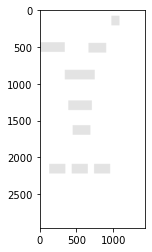

In [16]:
xmlstr = arg_env.get_current_state()
screen = ScreenObject(xmlstr, 1440, 2960)
screen.setRelevantComponents(["clickable"]) 
screen.buildScreenFromComponents()
screen.showScreen()


NUMBER OF CHANNELS: 1


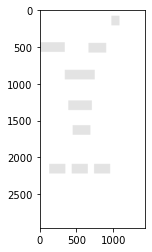

In [18]:
xmlstr = arg_env.get_current_state()
screen = ScreenObject(xmlstr, 1440, 2960)
screen.setRelevantComponents(["clickable"]) 
screen.createComponentChannels()
screen.showScreenChannels()

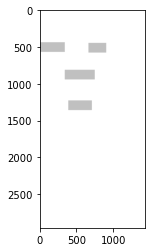

In [21]:
xmlstr = arg_env.get_current_state()
screen = ScreenObject(xmlstr, 1440, 2960)
screen.setRelevantComponents(["clickable"])
screen.setTileDimensions((2,2))
screen.buildTiledScreen()
screen.showTileinScreen((0,1))


NUMBER OF CHANNELS: 1


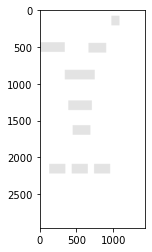

In [22]:
xmlstr = arg_env.get_current_state()
screen = ScreenObject(xmlstr, 1440, 2960)
screen.setRelevantComponents(["clickable"])
screen.buildTiledScreen()
screen.createComponentChannels(screen.tileScreen[2][2])
screen.showScreenChannels()
